<a href="https://colab.research.google.com/github/nedokormysh/GB_App_Statistics_Med/blob/lesson_4_multi_choice_corr/GB_app_statistics_med_hw_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Урок 4.
Планирование эксперимента и выбор метода анализа. Поправки на множественное тестирование


# Условие
Поработаем с таблицами, для которых на предыдущем
занятии вы изучали описательные статистики.

Сформулируйте несколько гипотез для 2 групп, которые
можно проверить на имеющихся данных. Укажите,
зависимые или независимые выборки, ЗП, НП.

Выберите подходящий тест и проверьте ваши
предположения.

Задание выполняется на языке R и предоставляется в
формате Google Colab.

In [1]:
# # Установка пакета car, если он еще не установлен
# if (!requireNamespace("car", quietly = TRUE)) {
#   install.packages("car")
# }

In [2]:
install.packages('tidyverse')
install.packages('skimr')
install.packages('psych')
# install.packages("car")
install.packages("ez")
install.packages("moments")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘mnormt’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘SparseM’, ‘MatrixModels’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘minqa’, ‘nloptr’, ‘Rcpp’, ‘RcppEigen’, ‘car’, ‘lme4’, ‘plyr’, ‘reshape2’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
library(tidyverse)
require(readxl)
library(skimr)
library(car)
library(ez)
library(moments)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: readxl

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some




# Загрузка данных

In [4]:
hdl <- read_tsv('https://raw.githubusercontent.com/nedokormysh/GB_App_Statistics_Med/lesson_2_descriptive_statistics/high_density_lipids.tsv') |>
  select(-Name) %>%
  mutate(Patient.number = as.factor(Patient.number),
         Vial.number = as.factor(Vial.number))

ldl <- read_tsv('https://raw.githubusercontent.com/nedokormysh/GB_App_Statistics_Med/lesson_2_descriptive_statistics/low_density_lipids.tsv') |>
  select(-Name) %>%
  mutate(Patient.number = as.factor(Patient.number),
         Vial.number = as.factor(Vial.number))

lipids <- full_join(hdl, ldl, by = c("Vial.number", "Patient.number"),
 suffix = c('hdl', 'ldl'))

Rows: 27 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Name
dbl (37): Vial.number, Patient.number, GPHDL1, GPHDL2, GPHDL3, GPHDL4, GPHDL...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 29 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Name
dbl (37): Vial.number, Patient.number, GPLDL1, GPLDL2, GPLDL3, GPLDL4, GPLDL...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
meta <- read_xlsx('/content/metadata.xlsx', sheet = 1) |>
  rename_with(make.names)

descriptive <- read_xlsx('/content/metadata.xlsx', sheet = 2) |>
  rename('Variable' = '...1', 'Description' = '...2') |>
  drop_na()

descriptive[10,]$Variable <- 'LVH'

for (col_name in colnames(meta)) {
  index <- match(col_name, descriptive$Variable)

  if (!is.na(index)) {
    attr(meta[[col_name]], 'label') <- descriptive$Description[index]
  }
}

In [6]:
# Выбираем столбцы с данными пациентов
patient_cols <- c('Vial.number',
                  'Patient.number',
                  'Name',
                  'Date',
                  'Age')


# Создаем таблицу с данными пациентов
patient_data <- meta[patient_cols]

# Создаем таблицу с клиническими данными
clinical_data <- meta |> select(-Name, -Age, -Date, -Sucrose)

# заменяем 3 точки на точку во всех названиях столбцов
colnames(clinical_data) <- sub("\\.+", ".", colnames(clinical_data))

colnames_factor = c('Vial.number', 'Patient.number', 'Group', 'Sm', 'Dm', 'HT',
                    'LVH', 'IHD', 'MI', 'Str', 'A_C', 'A_H', 'A_D', 'Plaque',
                    'Statins')

# преобразуем указанные столбцы в фактор
clinical_data[, colnames_factor] <- lapply(clinical_data[, colnames_factor], as.factor)

Сформулируйте несколько гипотез для 2 групп, которые можно проверить на имеющихся данных. Укажите, зависимые или независимые выборки, ЗП, НП.

# Гипотезы

## Гипотеза 1.A


Предположим, мы хотим проверить связь между толщиной бляшки (Plaque) и индексом массы тела (BMI). Мы можем сформулировать гипотезу следующим образом:

**Нулевая гипотеза (H0)**: Средние значения индекса массы тела (BMI) не различаются между группами с разной толщиной бляшки (Plaque).

**Альтернативная гипотеза (H1)**: Средние значения индекса массы тела (BMI) различаются между группами с разной толщиной бляшки (Plaque).


**Т.е. это у нас однофакторная ANOVA**

Индекс массы тела (BMI) в качестве зависимой переменной. Это численная переменная, значения которой мы сравниваем между группами.

Толщина бляшки (Plaque) в качестве независимой переменной. Это категориальная переменная, которая делит наблюдения на группы.

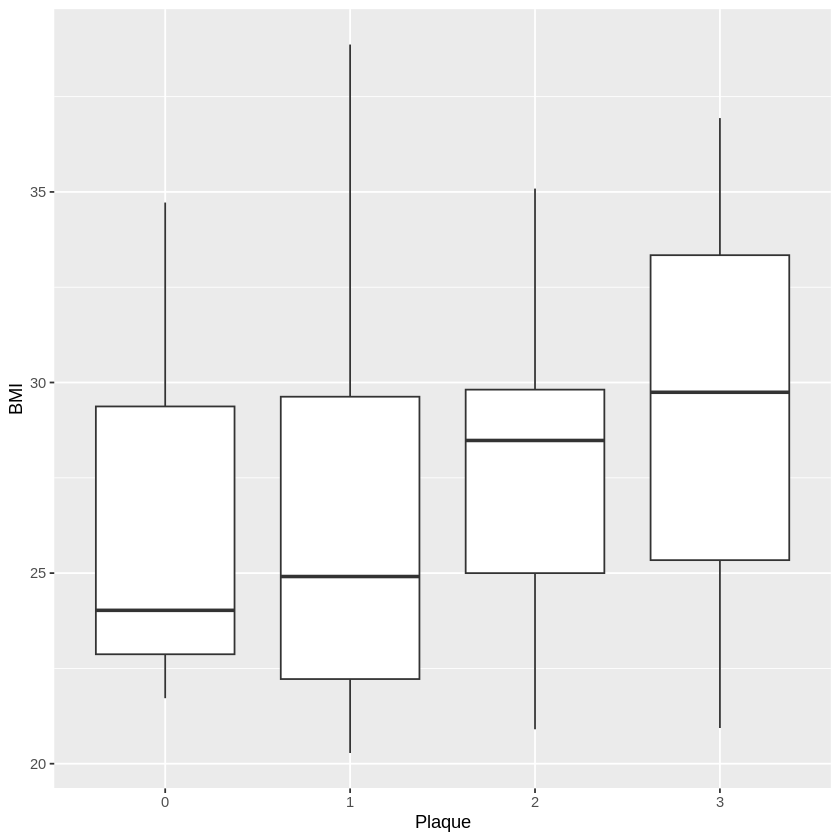

In [7]:
ggplot(clinical_data, aes(x = Plaque, y = BMI)) +
  geom_boxplot()

Разбросы в группах по размерам бляшек достаточно близки, но медианы отличаются.

In [8]:
# Проверка гипотезы с использованием ANOVA
BMI_aov <- aov(BMI ~ Plaque, data = clinical_data)
summary(BMI_aov)

            Df Sum Sq Mean Sq F value Pr(>F)
Plaque       3   25.4   8.454   0.292  0.831
Residuals   34  985.4  28.982               

В нашем случае значение p (Pr(>F)) равно 0.831, что превышает обычный порог статистической значимости. Это означает, что мы не можем отвергнуть нулевую гипотезу о равенстве средних значений индекса массы тела (BMI) между группами с разной толщиной бляшки (Plaque). Таким образом, нет достаточных оснований считать, что толщина бляшки влияет на индекс массы тела.

### Нормальность распределения остатков

In [9]:
# Проверка нормальности распределения остатков с помощью теста Шaпиро-Уилка
shapiro.test(residuals(BMI_aov))


	Shapiro-Wilk normality test

data:  residuals(BMI_aov)
W = 0.94071, p-value = 0.04418


В этом случае значение p (p-value) равно 0.04418, что меньше порога статистической значимости. Это означает, что мы можем отвергнуть нулевую гипотезу о нормальности распределения остатков.

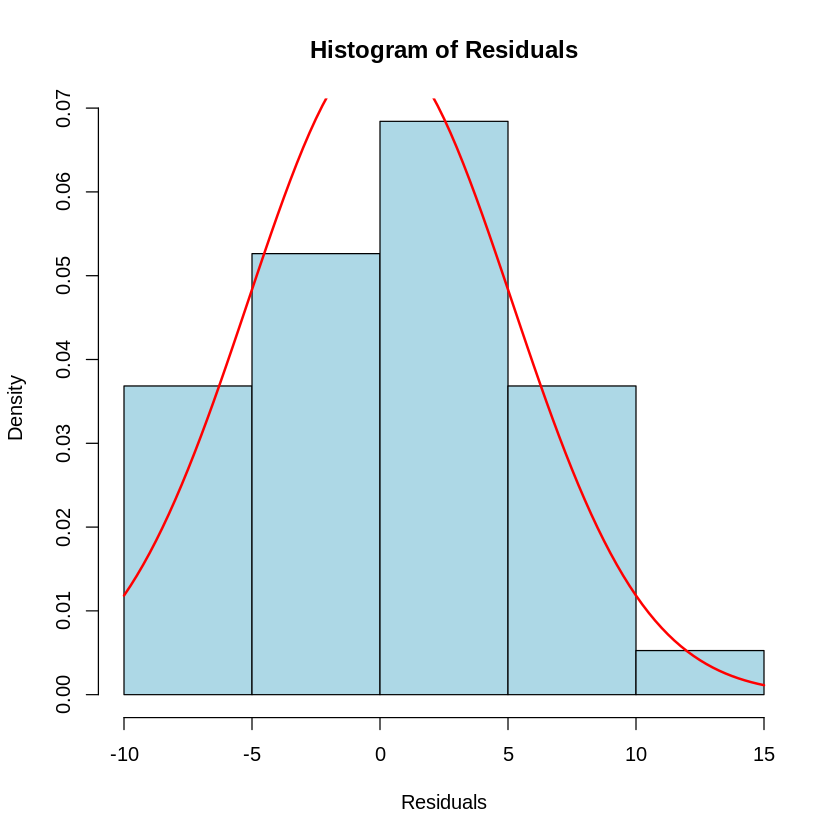

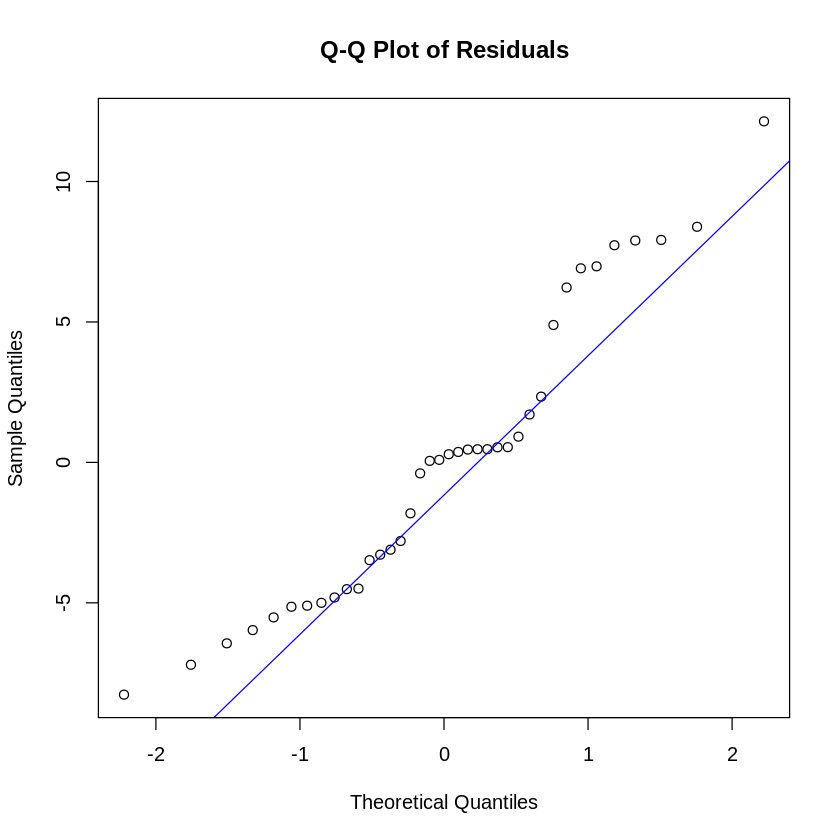

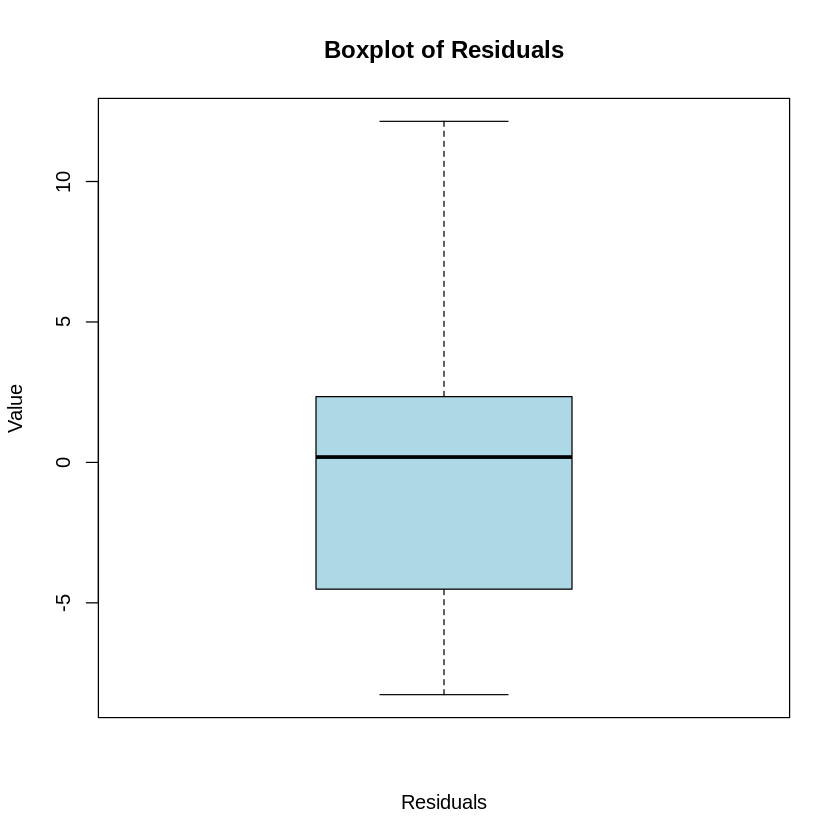

In [10]:
# Гистограмма остатков
hist(residuals(BMI_aov), main = "Histogram of Residuals", xlab = "Residuals", col = "lightblue", freq = FALSE)

# Добавление кривой нормального распределения
curve(dnorm(x, mean = mean(residuals(BMI_aov)), sd = sd(residuals(BMI_aov))),
      col = "red", lwd = 2, add = TRUE)

# Диаграмма Q-Q (quantile-quantile)
qqnorm(residuals(BMI_aov), main = "Q-Q Plot of Residuals", xlab = "Theoretical Quantiles", ylab = "Sample Quantiles")
qqline(residuals(BMI_aov), col = "blue")

# Бокс-плот остатков
boxplot(residuals(BMI_aov), main = "Boxplot of Residuals", xlab = "Residuals", ylab = "Value", col = "lightblue")

В принципе выбросов у нас нет. Я бы сказал, что распределение логнормально, поэтому считаю, что мы имеем право проводить параметрический тест, а не использовать Краскела-Уоллеса.

### Гомогенность дисперсий.

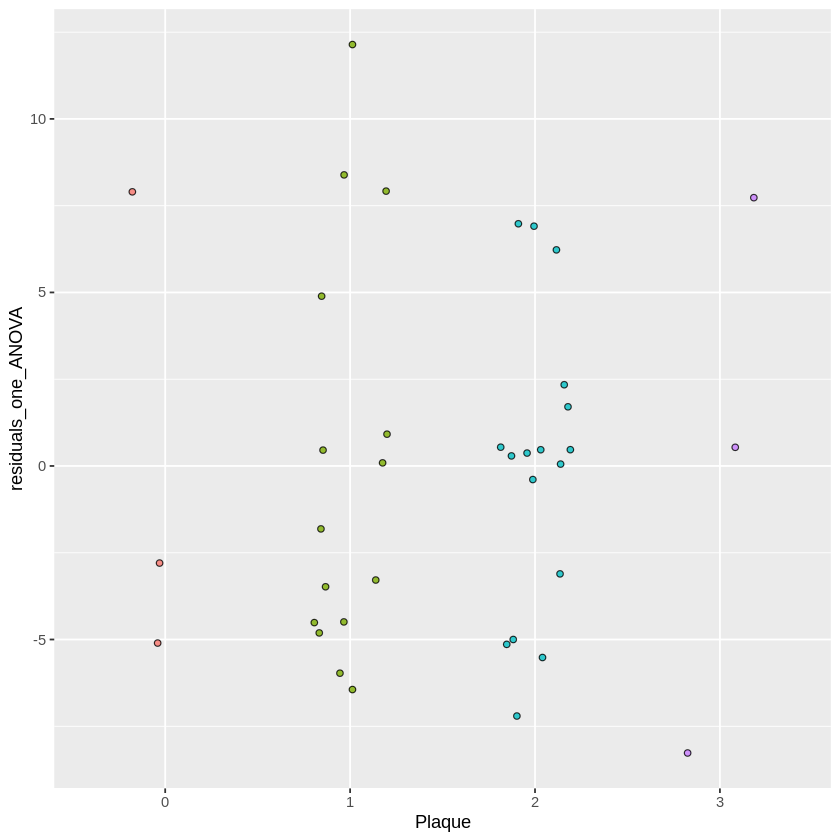

In [11]:
# Сохранение остатков в переменную
residuals_one_ANOVA <- residuals(BMI_aov)

ggplot(clinical_data, aes(x = Plaque, y = residuals_one_ANOVA, fill = Plaque)) +
  geom_jitter(width = 0.2, alpha = 0.8, shape = 21, color = "black") +
  theme(legend.position = "none")

К сожалению, выборки у нас достаточно отличаются. Насколько я понимаю, это из-за малого количества данных, возможно мы вообще не имеем право использовать anova, в данном случае. Но вроде бы всё таки у нас разница не на несколько порядков.

Визуально дисперсии достаточно похожи.

In [12]:
ez_model <- ezANOVA(data = clinical_data,
                    dv = BMI,
                    wid = Vial.number,
                    between = Plaque,
                    detailed = T,
                    return_aov = T)

Warning message:
“Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().”
Coefficient covariances computed by hccm()



In [13]:
ez_model

$ANOVA
  Effect DFn DFd      SSn      SSd         F         p p<.05        ges
1 Plaque   3  34 25.36265 985.3865 0.2917062 0.8310775       0.02509292

$`Levene's Test for Homogeneity of Variance`
  DFn DFd      SSn      SSd        F         p p<.05
1   3  34 25.10401 456.2538 0.623583 0.6046676      

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                  Plaque Residuals
Sum of Squares   25.3627  985.3865
Deg. of Freedom        3        34

Residual standard error: 5.383489
Estimated effects may be unbalanced


p уровень значимости, рассчитанный данной библиотекой близок, к рассчитанному выше стандартной библиотекой.

Тест Левена. В этом примере значение p равно 0.6046676, что превышает порог статистической значимости. Это означает, что мы не можем отвергнуть нулевую гипотезу о равенстве дисперсий между группами. Таким образом, на основании теста Левена можно считать, что предположение о равенстве дисперсий выполняется.

In [14]:
# # Проверка равенства дисперсий с помощью теста Бартлетта
# bartlett.test(BMI ~ Plaque, data = clinical_data)

# В этом примере значение p (p-value) равно 0.4647, что превышает обычный порог статистической значимости.
# Это означает, что мы не можем отвергнуть нулевую гипотезу о равенстве дисперсий между группами.
# Таким образом, на основании теста Бартлетта можно считать, что предположение о равенстве дисперсий выполняется.

In [15]:
# Проверка равенства дисперсий с помощью теста Левена
leveneTest(BMI ~ Plaque, data = clinical_data, center = mean)

,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,3,1.096268,0.3640355
,34,NA,NA


В этом примере значение p (Pr(>F)) равно 0.3640, что превышает порог статистической значимости. Это означает, что мы не можем отвергнуть нулевую гипотезу о равенстве дисперсий между группами. Таким образом, на основании теста Левена можно считать, что предположение о равенстве дисперсий выполняется.

Здесь значение достаточно сильно отличается от рассчитанного пакетом ez. Вот не смог понять в чём ошибка.

### Количество испытуемых

In [16]:
# # Подсчет количества испытуемых по группам Plaque
# group_counts <- table(clinical_data$Plaque)

# # Вывод результатов
# print(group_counts)

In [17]:
# Подсчет количества испытуемых по группам Plaque
clinical_data |>
  count(Plaque)

Plaque,n
<fct>,<int>
0,3
1,15
2,17
3,3


**Выводы:**
- У нас разное количество испытуемых в разных группах. По хорошему, считаю, что ANOVA здесь вообще не должна применяться.
- В принципе и однофакторный ANOVA возможно не стоит применять, всё таки распредление остатков у нас не нормально.

## Гипотеза 1.Б

**Нулевая гипотеза (H0):** Средние значения уровня триглицеридов (Tgi.26) не различаются между группами с различными размерами бляшек (Plaque).

**Альтернативная гипотеза (H1):** Средние значения уровня триглицеридов (Tgi.26) различаются между группами с различными размерами бляшек (Plaque).

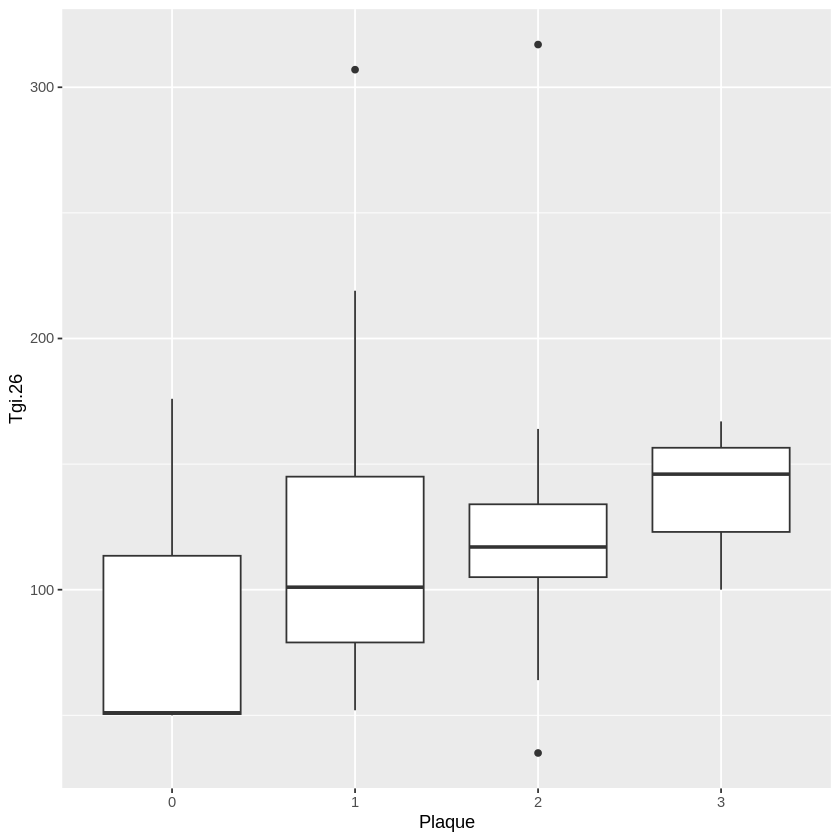

In [18]:
ggplot(clinical_data, aes(x = Plaque, y = Tgi.26)) +
  geom_boxplot()

У нас достаточно сильно различаются медианы и разбросы

In [19]:
# Проверка гипотезы с использованием ANOVA
TGI_aov <- aov(Tgi.26 ~ Plaque, data = clinical_data)
# summary(TGI_aov)

### Нормальность распределения остатков

In [20]:
# Проверка нормальности распределения остатков с помощью теста Шaпиро-Уилка
shapiro.test(residuals(TGI_aov))


	Shapiro-Wilk normality test

data:  residuals(TGI_aov)
W = 0.85253, p-value = 0.0001498


p-значение равно 0.0001498, которое меньше уровня значимости 0.05. Это означает, что нулевая гипотеза о нормальности распределения остатков должна быть отвергнута.

Не уверен, что означает требование: одинаковость распределений ЗП в каждой группе.
И в данном случае, учитывая количество объектов в каждой группе, мы в принципе видимо не можем проводить анализ.

In [21]:
# Применение теста Краскела-Уоллиса
kruskal_test <- kruskal.test(Tgi.26 ~ Plaque, data = clinical_data)

# Вывод результатов
print(kruskal_test)


	Kruskal-Wallis rank sum test

data:  Tgi.26 by Plaque
Kruskal-Wallis chi-squared = 2.0376, df = 3, p-value = 0.5646



p-значение равняется 0.5646. Это означает, что нулевая гипотеза о равенстве средних рангов уровня триглицеридов (Tgi.26) между группами с различными размерами бляшек (Plaque) не должна быть отвергнута, поскольку p-значение больше уровня значимости (обычно 0.05).

Таким образом, на основании этих результатов можно сделать вывод, что нет статистически значимых различий в уровне триглицеридов между группами с различными размерами бляшек.

In [22]:
# Подсчет количества испытуемых по группам Plaque
clinical_data |>
  count(Plaque)

Plaque,n
<fct>,<int>
0,3
1,15
2,17
3,3


**Выводы:**
- Вроде бы для однофакторного анализа нам подходит только Plaque. (либо создавать из непрерывных величин какие-нибудь дополнительные признаки)
- Количество объектов в некоторых группах слишком мало, и не факт, что тут можно применять тесты.

## Гипотеза 2.A

Допустим, что у нас есть две категориальные переменные: "Курение" (курящий и некурящий) и "История инфаркта миокарда". Мы хотим исследовать их влияние на уровень систолического артериального давления (САД) у пациентов.

**Нулевая гипотеза (H0):** Средние уровни систолического артериального давления не зависят от статуса курения и истории инфаркта миокарда у пациентов.

**Альтернативная гипотеза (H1):** Средние уровни систолического артериального давления зависят от статуса курения, истории инфаркта миокарда или их взаимодействия у пациентов.

В этом примере мы хотим проверить, есть ли статистически значимое влияние статуса курения, истории инфаркта миокарда или их взаимодействия на уровень систолического артериального давления у пациентов.

**Двухфакторная ANOVA** позволит нам оценить эти эффекты и определить, существует ли статистически значимое влияние каждого фактора и их взаимодействия на уровень систолического артериального давления.

In [23]:
# Проводим двухфакторную ANOVA
Sm_MI_aov <- aov(Sys ~ Sm * MI, data = clinical_data)

# Выводим результаты
summary(Sm_MI_aov)

            Df Sum Sq Mean Sq F value Pr(>F)
Sm           1     10    9.83   0.037  0.849
MI           1    155  155.31   0.582  0.451
Residuals   35   9336  266.75               

Согласно результатам, для обоих факторов (Sm и MI) p-значения превышают 0.05 (Sm: p = 0.849, MI: p = 0.451). Это означает, что мы не можем отвергнуть нулевую гипотезу о том, что средние значения BMI не зависят от факторов Sm и MI. Таким образом, мы не можем утверждать, что курение или инфаркт миокарда оказывают статистически значимое влияние на индекс массы тела.

### Нормальность распределения остатков

In [24]:
# Проверка нормальности распределения остатков с помощью теста Шaпиро-Уилка
shapiro.test(residuals(Sm_MI_aov))


	Shapiro-Wilk normality test

data:  residuals(Sm_MI_aov)
W = 0.91631, p-value = 0.007605


p-значение равняется 0.007605, что меньше 0.05. Таким образом, мы можем отвергнуть нулевую гипотезу о том, что остатки нормально распределены. Это означает, что предположение о нормальности распределения остатков не выполняется.

Так как предположение о нормальности распределения остатков нарушено, то мы не можем использовать ANOVA для анализа.

In [25]:
# # Тест Краскела-Уоллиса для фактора Sm
# kruskal.test(Sys ~ Sm, data = clinical_data)

# # Тест Краскела-Уоллиса для фактора MI
# kruskal.test(Sys ~ MI, data = clinical_data)

## Гипотеза 2.Б

Мы хотим исследовать  влияние категориальных переменных курение и история инфаркта миокарда на уровень холистерола (Choi.25) у пациентов.

**Нулевая гипотеза (H0):** Средние уровни систолического артериального давления не зависят от статуса курения и истории инфаркта миокарда у пациентов.

**Альтернативная гипотеза (H1):** Средние уровни систолического артериального давления зависят от статуса курения, истории инфаркта миокарда или их взаимодействия у пациентов.



В этом примере мы хотим проверить, есть ли статистически значимое влияние статуса курения, истории инфаркта миокарда или их взаимодействия на уровень холистерола у пациентов.

In [26]:
# install.packages("Hmisc")  # Install the package
# library(Hmisc)  # Load the package

Warning message:
“Computation failed in `stat_summary()`
Caused by error in `fun.data()`:
! The package "Hmisc" is required.”
Warning message:
“Computation failed in `stat_summary()`
Caused by error in `fun.data()`:
! The package "Hmisc" is required.”
Warning message:
“Computation failed in `stat_summary()`
Caused by error in `fun.data()`:
! The package "Hmisc" is required.”


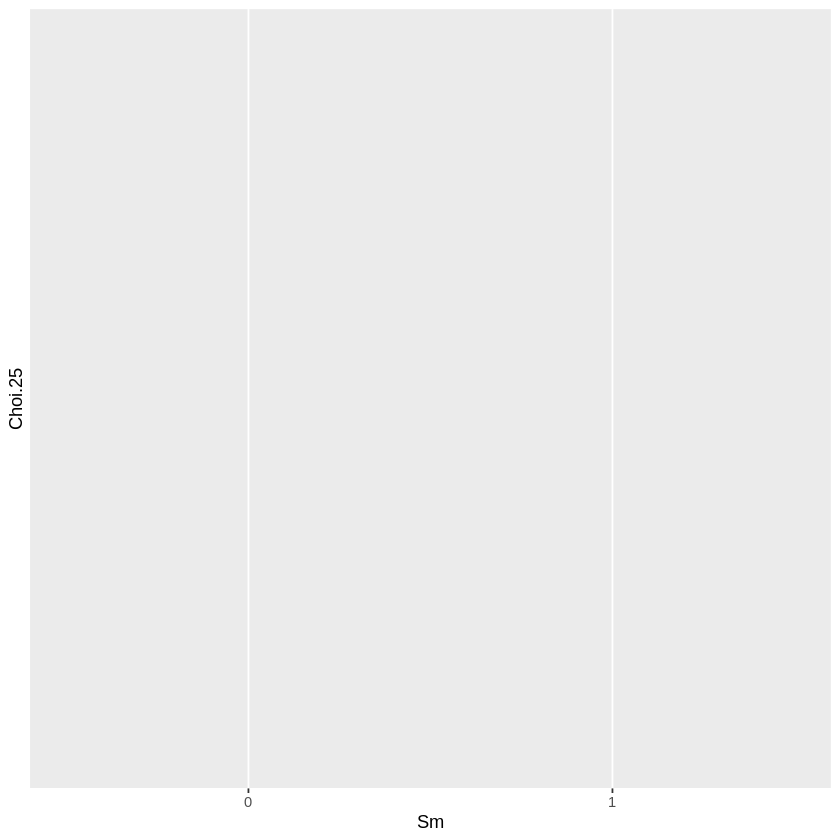

In [27]:
# library(ggplot2)
obj <- ggplot(clinical_data, aes(x = Sm, y = Choi.25, col = MI , group = MI))+
  stat_summary(fun.data = mean_cl_boot, geom = 'errorbar', width = 0.1, position = position_dodge(0.2))+
  stat_summary(fun.data = mean_cl_boot, geom = 'point', size = 3, position = position_dodge(0.2))+
  stat_summary(fun.data = mean_cl_boot, geom = 'line', position = position_dodge(0.2))
print(obj)

Видимо у нас нет курящих людей с инфактом в анамнезе.

In [28]:
# Проводим двухфакторную ANOVA
Choi_Sm_MI_aov <- aov(Choi.25 ~ Sm * MI, data = clinical_data)

# Выводим результаты
summary(Choi_Sm_MI_aov)

shapiro.test(residuals(Choi_Sm_MI_aov))

            Df Sum Sq Mean Sq F value Pr(>F)
Sm           1      4     3.7   0.002  0.964
MI           1    345   344.6   0.193  0.663
Residuals   35  62363  1781.8               


	Shapiro-Wilk normality test

data:  residuals(Choi_Sm_MI_aov)
W = 0.97072, p-value = 0.4113


Значения p-value для всех трех эффектов (Sm, MI и взаимодействие Sm) превышают уровень значимости. Это означает, что нулевые гипотезы о равенстве средних значений уровня холестерина между группами для каждого эффекта не должны быть отвергнуты.

Тест Шaпиро-Уилка на нормальность остатков показывает, что p-значение равняется 0.4113, что также превышает уровень значимости. Это означает, что нулевая гипотеза о нормальности распределения остатков не должна быть отвергнута.

Можно сделать вывод, что нет статистически значимых различий в уровне холестерина между группами с различными комбинациями факторов Sm и MI, и что остатки нормально распределены.

In [29]:
# # Сохранение остатков в переменную
# residuals_two_ANOVA <- residuals(Choi_Sm_MI_aov)

# ggplot(clinical_data, aes(x = Plaque, y = residuals_two_ANOVA, fill = Plaque)) +
#   geom_jitter(width = 0.2, alpha = 0.8, shape = 21, color = "black") +
#   theme(legend.position = "none")

## Гипотеза 3.

Нулевая гипотеза (H0): Среднее значения GPHDL2 и GPLDL5 не различаются между группами (диабет и без диабета)

Альтернативная гипотеза (H1): Средние уровни  GPHDL2 и GPLDL5 различаются между группами (диабет и без диабета).


**MANOVA** для проверки нулевой гипотезы (H0) о том, что средние значения GPHDL2 и GPLDL5 не различаются между группами (диабет и без диабета).

Зависимые переменные: GPHDL2 и GPLDL5

Независимая переменная: Dm


Зависимые переменные выбрал наугад.

In [30]:
combined_data <- merge(lipids, clinical_data, by = c("Vial.number", "Patient.number"))

In [31]:
dependent_vars <- c("GPHDL2", "GPLDL5")
dependent_matrix <- as.matrix(combined_data[, dependent_vars])

In [32]:
manova_result <- manova(dependent_matrix ~ Dm, data = combined_data)
summary(manova_result, test = "Wilks")

          Df   Wilks approx F num Df den Df Pr(>F)
Dm         1 0.89411   1.4211      2     24  0.261
Residuals 25                                      

Значение p (0.261) превышает обычный порог значимости. Это означает, что нулевая гипотеза о том, что средние значения зависимых переменных (GPHDL2 и GPLDL5) не различаются между группами Dm, не может быть отвергнута. На основании этих данных нет достаточных доказательств для утверждения, что переменные GPHDL2 и GPLDL5 значимо различаются между группами Dm.

### Независимость переменных

In [33]:
correlation <- cor.test(combined_data$GPHDL2, combined_data$GPLDL5, method = "pearson")
correlation_coefficient <- correlation$estimate
p_value <- correlation$p.value

print(correlation_coefficient)

        cor 
-0.07061239 


In [34]:
print(p_value)

[1] 0.7263475


Коэффициент корреляции Пирсона близок к нулю (-0.07061239), что указывает на отсутствие линейной зависимости между переменными GPHDL2 и GPLDL5. Значение p (0.7263475) превышает обычный порог значимости. Это означает, что нулевая гипотеза о том, что корреляция между переменными равна нулю, не может быть отвергнута. В других словах, на основании этих данных нет достаточных доказательств для утверждения, что между переменными GPHDL2 и GPLDL5 существует линейная зависимость.

### Симметричность распределения

Warning message:
“Removed 2 rows containing non-finite values (`stat_density()`).”


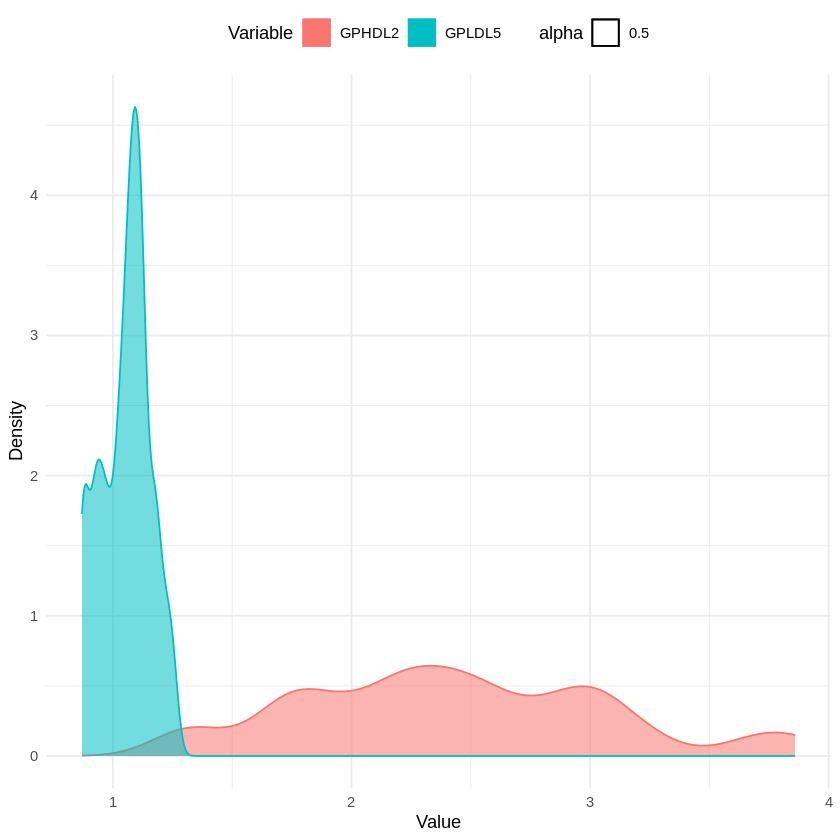

In [35]:
ggplot(combined_data, aes(x = GPHDL2, fill = "GPHDL2", color = "GPHDL2", alpha = 0.5)) +
  geom_density(adjust = 0.5) +
  geom_density(aes(x = GPLDL5, fill = "GPLDL5", color = "GPLDL5", alpha = 0.5), adjust = 0.5) +
  labs(x = "Value", y = "Density", fill = "Variable", color = "Variable") +
  theme_minimal() +
  theme(legend.position = "top")

Warning message:
“Removed 2 rows containing non-finite values (`stat_density()`).”


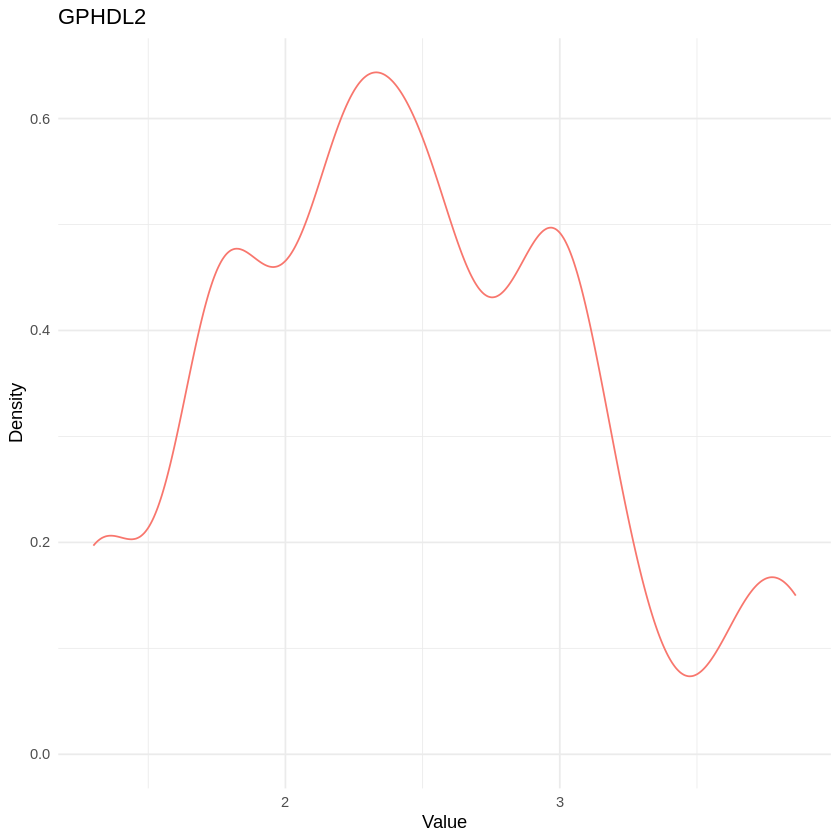

In [36]:
ggplot(combined_data, aes(x = GPHDL2,# fill = "GPHDL2",
 color = "GPHDL2", alpha = 0.5)) +
  geom_density(adjust = 0.5) +
  labs(x = "Value", y = "Density", fill = "Variable", color = "Variable") +
  theme_minimal() +
  theme(legend.position = "none") +
  ggtitle("GPHDL2")

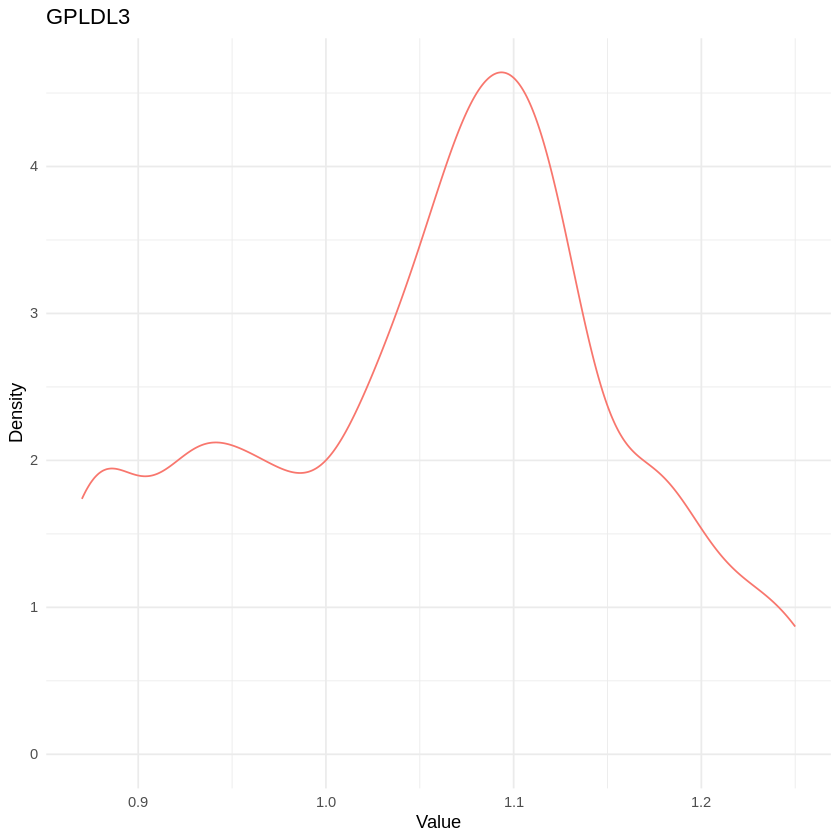

In [37]:
ggplot(combined_data, aes(x = GPLDL5, #fill = "GPLDL5",
 color = "GPLDL5", alpha = 0.5)) +
  geom_density(adjust = 0.5) +
  labs(x = "Value", y = "Density", fill = "Variable", color = "Variable") +
  theme_minimal() +
  theme(legend.position = "none") +
  ggtitle("GPLDL3")

In [38]:
# unique(combined_data$GPHDL2)

In [39]:
skewness(combined_data$GPHDL2[!is.na(combined_data$GPHDL2)])
skewness(combined_data$GPLDL5[!is.na(combined_data$GPLDL5)])

[1] 0.2919669

[1] -0.1761128

In [40]:
shapiro.test(combined_data$GPHDL2)
shapiro.test(combined_data$GPLDL5)


	Shapiro-Wilk normality test

data:  combined_data$GPHDL2
W = 0.97988, p-value = 0.8597



	Shapiro-Wilk normality test

data:  combined_data$GPLDL5
W = 0.96903, p-value = 0.5337


Не совсем понимаю критерий симметричности, но  вроде бы можно считать распределения симметричными.

**Выводы**
- Могли провести MANOVA, но различий не выявили.

In [41]:
install.packages('MASS')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [42]:
library('MASS')


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




In [43]:
# lda(combined_data$Dm ~ combined_data$GPHDL2 * combined_data$GPLDL5, CV = F)

## Гипотеза 4.

**Нулевая гипотеза (H0):** Средние значения интима-медиальной толщины сонной артерии, связанные с систолическим артериальным давлением, не различаются между группами пациентов (здоровые и больные атеросклерозом).

**Альтернативная гипотеза (H1):** Средние значения интима-медиальной толщины сонной артерии, связанные с систолическим артериальным давлением, различаются между группами пациентов (здоровые и больные атеросклерозом).

Зависимая переменная: среднее значение толщины сонной артерии

Ковариата: систолическое артериальное давление

Независимая переменная: группа здоровья

In [44]:
ancova_model <- aov(carotid.IMT.mean ~ Group + Sys, data = clinical_data)

In [45]:
summary(ancova_model)

            Df Sum Sq Mean Sq F value Pr(>F)  
Group        1 0.0855 0.08554   6.288 0.0169 *
Sys          1 0.0107 0.01074   0.790 0.3803  
Residuals   35 0.4762 0.01360                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

На основании этих результатов можем отклонить нулевую гипотезу о том, что средние значения carotid.IMT.mean, связанные с ковариатом Sys, не различаются между группами. Альтернативная гипотеза, что средние значения carotid.IMT.mean, корректируемые по ковариату Sys, различаются между группами, подтверждается.

### Нормальность распределения остатков.

In [46]:
# Проверка нормальности распределения остатков с помощью теста Шaпиро-Уилка
shapiro.test(residuals(ancova_model))


	Shapiro-Wilk normality test

data:  residuals(ancova_model)
W = 0.94973, p-value = 0.08722


В этом случае значение p (p-value) равно 0.08722, что меньше порога статистической значимости. Это означает, что мы можем отвергнуть нулевую гипотезу о нормальности распределения остатков.

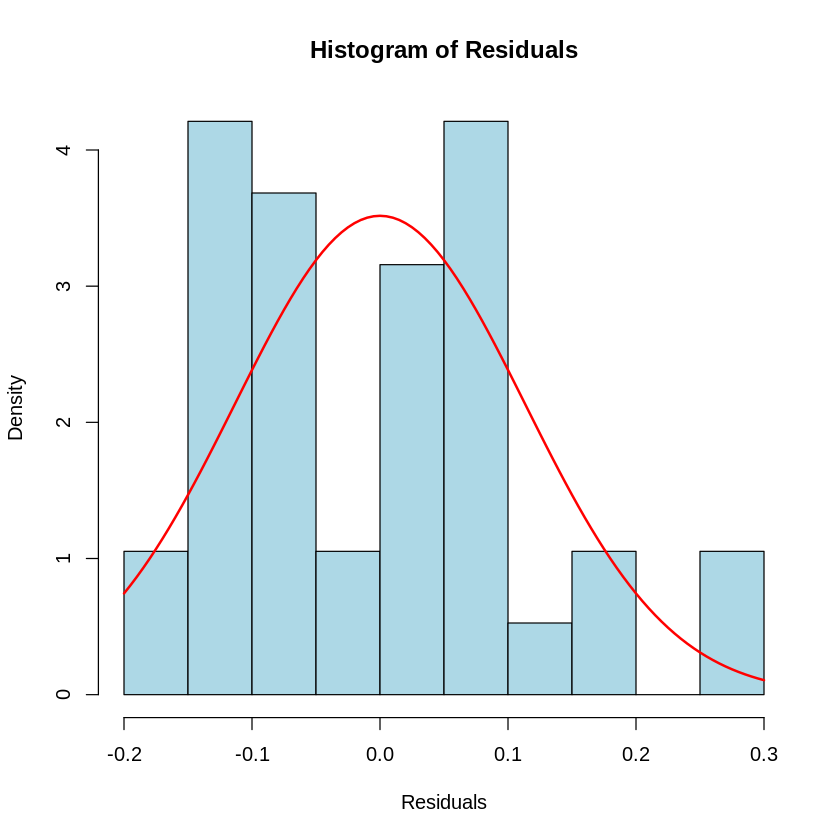

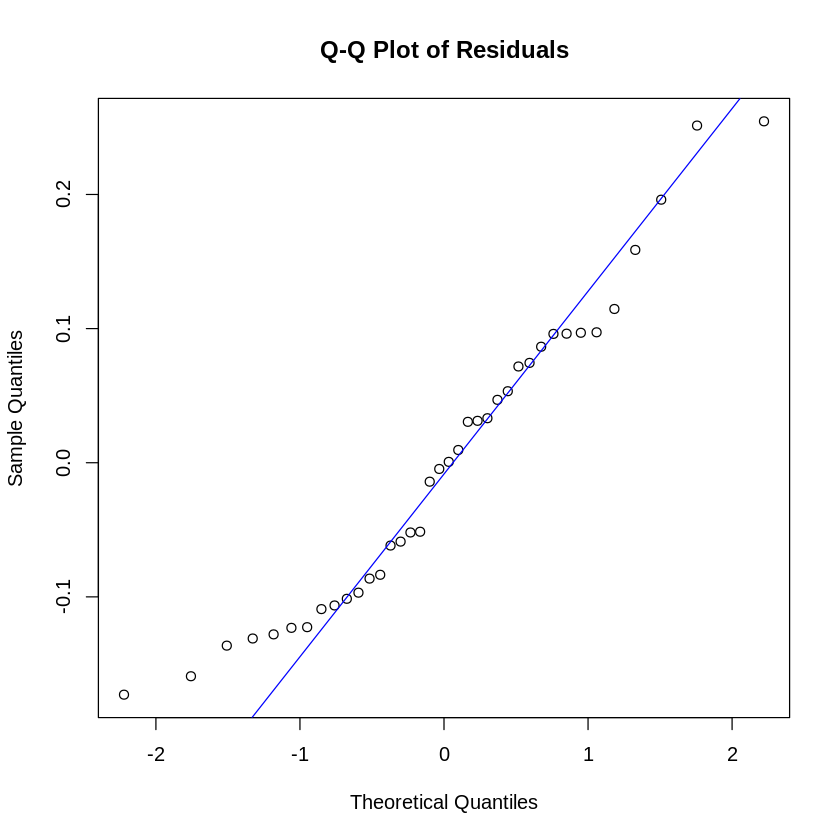

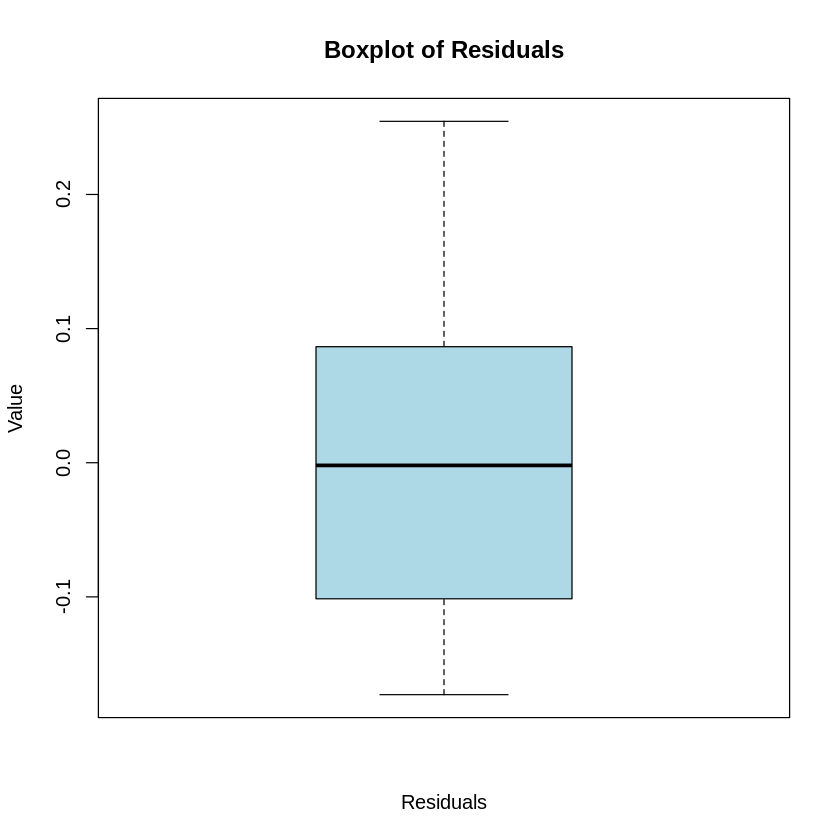

In [47]:
# Гистограмма остатков
hist(residuals(ancova_model), main = "Histogram of Residuals", xlab = "Residuals", col = "lightblue", freq = FALSE)

# Добавление кривой нормального распределения
curve(dnorm(x, mean = mean(residuals(ancova_model)), sd = sd(residuals(ancova_model))),
      col = "red", lwd = 2, add = TRUE)

# Диаграмма Q-Q (quantile-quantile)
qqnorm(residuals(ancova_model), main = "Q-Q Plot of Residuals", xlab = "Theoretical Quantiles", ylab = "Sample Quantiles")
qqline(residuals(ancova_model), col = "blue")

# Бокс-плот остатков
boxplot(residuals(ancova_model), main = "Boxplot of Residuals", xlab = "Residuals", ylab = "Value", col = "lightblue")

Всё таки по графикам вроде бы не всё так плохо. У нас только хвосты достаточно тяжёлые

### Гомогенность дисперсий.

Не понял как проверить.

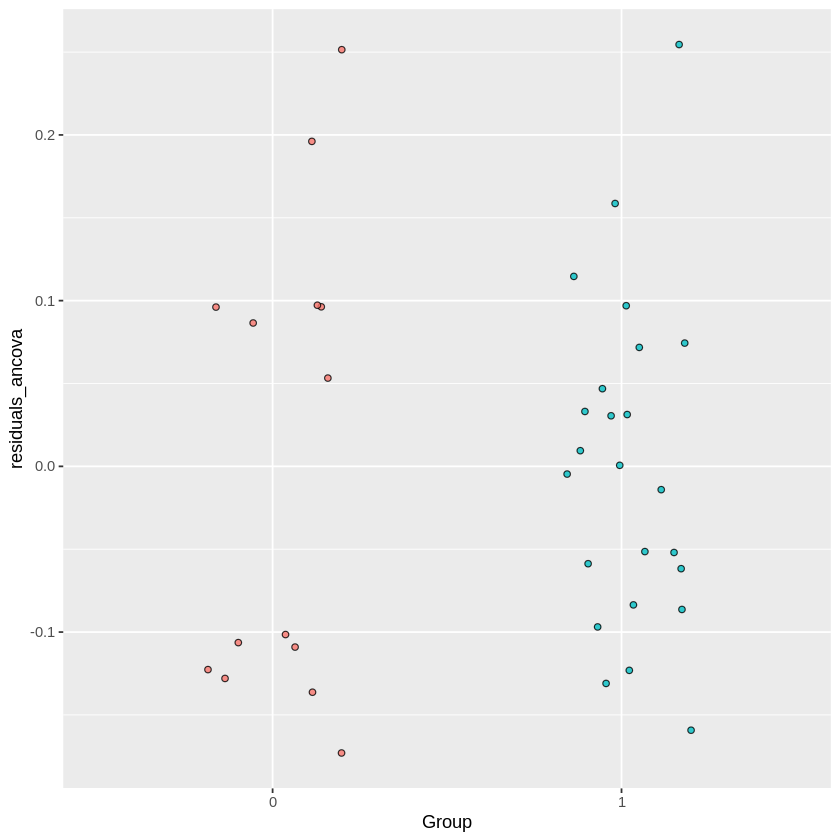

In [48]:
# Сохранение остатков в переменную
residuals_ancova <- residuals(ancova_model)

ggplot(clinical_data, aes(x = Group, y = residuals_ancova, fill = Group)) +
  geom_jitter(width = 0.2, alpha = 0.8, shape = 21, color = "black") +
  theme(legend.position = "none")

### Количество испытуемых.

In [49]:
clinical_data |>
  count(Group)

Group,n
<fct>,<int>
0,14
1,24


По группам тоже есть достаточно большое различие.

У нас разный размер выборок, но дисперсии не понимаю как проверить. Распределение остатков ненормально.

Насколько понимаю, можно применить критерий Данна. но применить у меня не удалось. Только ошибки.

In [50]:
install.packages("rstatix")
library(rstatix)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘corrplot’



Attaching package: ‘rstatix’


The following object is masked from ‘package:MASS’:

    select


The following object is masked from ‘package:stats’:

    filter




In [52]:
dunn_test(formula=clinical_data$carotid.IMT.mean ~ clinical_data$Group + clinical_data$Sys, p.adjust.method = 'none')

ERROR: Error in dunn_test(formula = clinical_data$carotid.IMT.mean ~ clinical_data$Group + : argument "data" is missing, with no default


In [53]:
dunn_test(data=clinical_data, formula=carotid.IMT.mean ~ Group + Sys, p.adjust.method = 'none')

ERROR: [1m[33mError[39m in `pull()`:[22m
[1m[22m[33m![39m `!!enquo(var)` must select exactly one column.


In [ ]:
install.packages("FSA")
library(FSA)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘zoo’, ‘dunn.test’, ‘lmtest’, ‘plotrix’


Registered S3 methods overwritten by 'FSA':
  method       from
  confint.boot car 
  hist.boot    car 

## FSA v0.9.5. See citation('FSA') if used in publication.
## Run fishR() for related website and fishR('IFAR') for related book.


Attaching package: ‘FSA’


The following object is masked from ‘package:car’:

    bootCase




In [ ]:
# сохраняем остатки в переменную
ancova_residuals <- resid(ancova_model)

In [ ]:
# Создаём новую переменную, содержащую прогнозируемые значения для зависимой переменной (carotid.IMT.mean) с учетом только ковариата (Sys):
ancova_fitted_values <- fitted(ancova_model)

In [ ]:
# вычитаем прогнозируемые значения из исходной зависимой переменной:
adjusted_carotid_IMT <- clinical_data$carotid.IMT.mean - ancova_fitted_values

In [ ]:
dunn_test <- dunnTest(adjusted_carotid_IMT ~ Group, data = clinical_data, method = "holm")
print(dunn_test)

ERROR: Error in Psort[1, i]: incorrect number of dimensions


In [ ]:
# Удаляем строки с пропусками
clinical_data_complete <- na.omit(clinical_data)

# Создаем ANCOVA модель
ancova_model <- aov(carotid.IMT.mean ~ Group + Sys, data = clinical_data_complete)

# Вычитаем прогнозируемые значения из исходной зависимой переменной
ancova_fitted_values <- fitted(ancova_model)
adjusted_carotid_IMT <- clinical_data_complete$carotid.IMT.mean - ancova_fitted_values

# Проверяем длину векторов
length(adjusted_carotid_IMT)
length(clinical_data_complete$Group)

# Применяем критерий Данна
dunn_test <- dunnTest(adjusted_carotid_IMT ~ Group, data = clinical_data_complete, method = "holm")
print(dunn_test)

[1] 27

[1] 27

ERROR: Error in Psort[1, i]: incorrect number of dimensions


In [ ]:
install.packages("dunn.test")
library(dunn.test)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Загружаем пакет dunn.test
library(dunn.test)

# Применяем критерий Данна
dunn_test <- dunn.test(adjusted_carotid_IMT, clinical_data_complete$Group, method = "holm")
print(dunn_test)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



  Kruskal-Wallis rank sum test

data: adjusted_carotid_IMT and group
Kruskal-Wallis chi-squared = 0.1102, df = 1, p-value = 0.74



ERROR: Error in Psort[1, i]: incorrect number of dimensions


In [ ]:
adjusted_carotid_IMT <- clinical_data$carotid.IMT.mean - ancova_fitted_values

In [ ]:
dunn_test <- dunn.test(adjusted_carotid_IMT, clinical_data$Group, method = "holm")
print(dunn_test)

  Kruskal-Wallis rank sum test

data: adjusted_carotid_IMT and group
Kruskal-Wallis chi-squared = 0.0586, df = 1, p-value = 0.81



ERROR: Error in Psort[1, i]: incorrect number of dimensions


в Данна только нужно писать названия колонок, а в data запихнуть табличку.
Вторая ошибка в Данна вызвана тем, что вы пытаетесь засунуть в тест и вектор вне таблицы, и из таблицы.